In [ ]:
from datetime import datetime, timedelta
from typing import Any, Dict, List, Optional
import torch
from pathlib import Path
import numpy as np
from numpy import nan
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from scipy.stats import entropy as scipy_entropy
import sys

In [2]:
dfX = pd.read_csv('/Users/rosssponholtz/data/eicu-combined/combined_samples.csv')
dfy = pd.read_csv('/Users/rosssponholtz/data/eicu-combined/combined_labels.csv')

dfX.drop(['mortality0'], axis=1, inplace=True)
dfX.drop(['patientunitstay'], axis=1, inplace=True)
dfy["mortality"] = dfy["mortality"].astype(int)

In [3]:
param_grid = {
    'n_estimators': [ 300],
    'max_depth': [  14],
    'learning_rate': [0.01],
    'subsample': [ 0.8, 0.9],
    'colsample_bytree': [0.4],
    'reg_alpha': [0.15],
    'reg_lambda': [ 0.15],
    'objective': ['binary:logistic']
}
DoHyperparameterTuning = False

if DoHyperparameterTuning:
    xgb = XGBClassifier(eval_metric='auc')
    random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=50, cv=3, scoring='roc_auc', verbose=1, random_state=42, n_jobs=-1)
    random_search.fit(dfX, dfy)

    print("Best parameters found: ", random_search.best_params_)
    print("Best accuracy found: ", random_search.best_score_)

In [ ]:
def calculate_kl_divergence(file1, file2, column=None, bins=10):
    """
    Calculate Kullback-Leibler divergence between two CSV files.
    
    Parameters:
    -----------
    file1 : str
        Path to first CSV file
    file2 : str
        Path to second CSV file
    column : str, optional
        Column name to compare. If None, compares all numeric columns
    bins : int, default=10
        Number of bins for histogram discretization
    """
    # Load CSV files
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    
    print(f"Loaded {file1}: {df1.shape[0]} rows, {df1.shape[1]} columns")
    print(f"Loaded {file2}: {df2.shape[0]} rows, {df2.shape[1]} columns")
    print()
    
    # Get numeric columns
    numeric_cols1 = df1.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols2 = df2.select_dtypes(include=[np.number]).columns.tolist()
    
    if column:
        # Compare specific column
        if column not in numeric_cols1 or column not in numeric_cols2:
            print(f"Error: Column '{column}' not found in both files or not numeric")
            return
        
        columns_to_compare = [column]
    else:
        # Find common numeric columns
        columns_to_compare = list(set(numeric_cols1) & set(numeric_cols2))
        if not columns_to_compare:
            print("No common numeric columns found between the two files")
            return
    
    print(f"Comparing {len(columns_to_compare)} column(s):")
    print()
    
    # Calculate KL divergence for each column
    total_kl = 0
    for col in columns_to_compare:
        values1 = df1[col].dropna().values
        values2 = df2[col].dropna().values
        
        # Normalize to distributions
        p = normalize_distribution(values1, bins=bins)
        q = normalize_distribution(values2, bins=bins)
        
        # Calculate KL divergence: D_KL(P || Q)
        kl_div = scipy_entropy(p, q)
        total_kl += kl_div
        
        print(f"Column: {col}")
        print(f"  File 1 - min: {values1.min():.4f}, max: {values1.max():.4f}, mean: {values1.mean():.4f}")
        print(f"  File 2 - min: {values2.min():.4f}, max: {values2.max():.4f}, mean: {values2.mean():.4f}")
        print(f"  KL Divergence (File1 || File2): {kl_div:.6f}")
        print()
    
    # Print summary
    print(f"Average KL Divergence across {len(columns_to_compare)} column(s): {total_kl / len(columns_to_compare):.6f}")
    print(f"Total KL Divergence: {total_kl:.6f}")


In [4]:
def run_model(dfX,dfy):
    X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, test_size=.2)

    #self.model = XGBClassifier(n_estimators=250, max_depth=9, learning_rate=0.01, subsample=0.6, colsample_bytree=0.4, reg_alpha=0.1, reg_lambda=0.1, objective='binary:logistic')      
    model = XGBClassifier(n_estimators=300, max_depth=14, learning_rate=0.01, subsample=0.8, colsample_bytree=0.4, reg_alpha=0.15, reg_lambda=0.15, objective='binary:logistic')      
    #model = XGBClassifier()      
    model.fit(X_train, y_train)
    # make predictions
    preds = model.predict(X_test)
    # evaluate predictions
    model.score(X_test,y_test)

    print(f"Model: {model}")
    print(f"Score: {model.score(X_test, y_test)}")
    print(f"Predictions: {model.predict(X_test)}")
    #print(f"Feature Importances: {self.model.feature_importances_}")
    #print(f"Selected Features: {self.model.selected_features}")
    print(f"Model: {model}")
    print(f"Model: {model.get_params()}")
    print(f"Classification Report:\n{classification_report(y_test, preds)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, preds)}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, preds)}")

    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for the positive class (class 1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                            estimator_name='XGBClassifier')
    display.plot()
    plt.title('ROC Curve')
    plt.show()
    return model

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)
Score: 0.9164921711410444
Predictions: [0 0 0 ... 0 0 0]
Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, e

/Users/rosssponholtz/code/cs598dlh-project/.venv/lib/python3.11/site-packages/sklearn/utils/_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


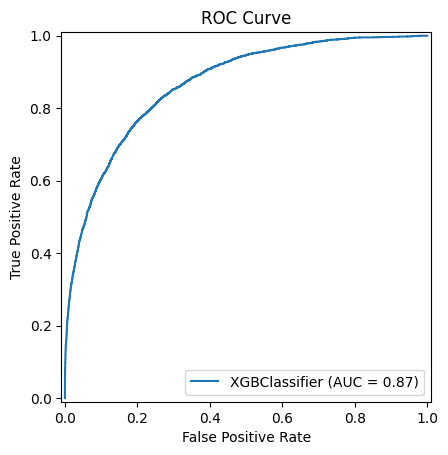

In [5]:
model = run_model(dfX, dfy)

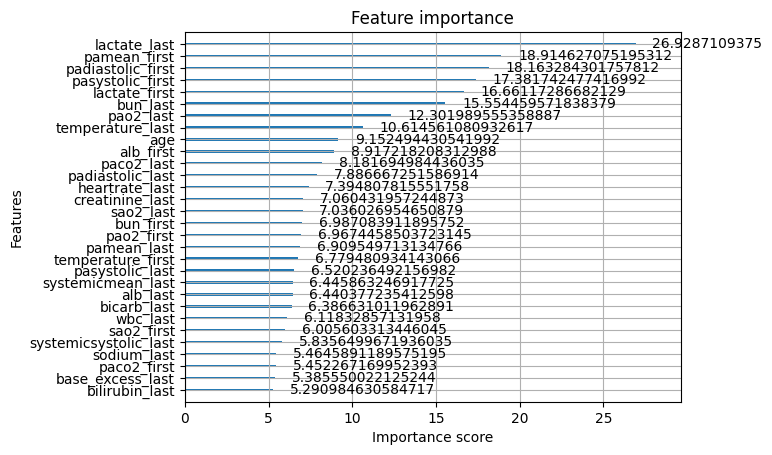

In [6]:
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

plot_importance(model, max_num_features=30, importance_type='gain')
plt.show()

In [7]:
# Get feature importance scores
importance_scores = model.get_booster().get_score(importance_type='gain')

# importance_type can be 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
# 'gain' is the default and represents the average gain achieved when a feature is used for splitting
# 'weight' is the number of times a feature is used in a tree
# 'cover' is the average number of training instances that a feature is used to split on
#sort the importance scores in descending order
importance_scores = dict(sorted(importance_scores.items(), key=lambda item: item[1], reverse=True))

for feature, score in list(importance_scores.items())[0:30]:
    print(f"Feature: {feature}, Importance Score: {score}")



Feature: lactate_last, Importance Score: 26.9287109375
Feature: pamean_first, Importance Score: 18.914627075195312
Feature: padiastolic_first, Importance Score: 18.163284301757812
Feature: pasystolic_first, Importance Score: 17.381742477416992
Feature: lactate_first, Importance Score: 16.66117286682129
Feature: bun_last, Importance Score: 15.554459571838379
Feature: pao2_last, Importance Score: 12.301989555358887
Feature: temperature_last, Importance Score: 10.614561080932617
Feature: age, Importance Score: 9.152494430541992
Feature: alb_first, Importance Score: 8.917218208312988
Feature: paco2_last, Importance Score: 8.181694984436035
Feature: padiastolic_last, Importance Score: 7.886667251586914
Feature: heartrate_last, Importance Score: 7.394807815551758
Feature: creatinine_last, Importance Score: 7.060431957244873
Feature: sao2_last, Importance Score: 7.036026954650879
Feature: bun_first, Importance Score: 6.987083911895752
Feature: pao2_first, Importance Score: 6.9674458503723145


In [8]:
#create new prediction with just the top 10 features
selected_columns = ['lactate_last',
'pamean_first',
'pasystolic_first',
'padiastolic_first',
'lactate_first',
'bun_last',
'pao2_last',
'temperature_last',
'alb_first',
'age',
'padiastolic_last',
'paco2_last',
'pasystolic_last',
'pamean_last',
'sao2_last',
'creatinine_last',
'heartrate_last',
'temperature_first',
'bun_first',
'systemicmean_last',
'alb_last',
'bicarb_last',
'pao2_first',
'sao2_first',
'wbc_last',
'paco2_first',
'systemicsystolic_last',
'sodium_last',
'bilirubin_last',
'base_excess_last']



Running model with top 10 features:
Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)
Score: 0.9153358127324437
Predictions: [0 0 0 ... 0 0 0]
Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
            

/Users/rosssponholtz/code/cs598dlh-project/.venv/lib/python3.11/site-packages/sklearn/utils/_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


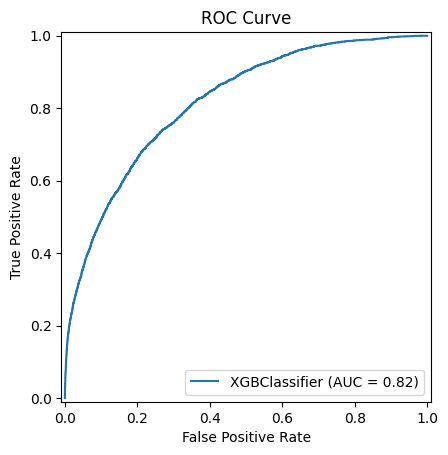



Running model with top 15 features:
Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)
Score: 0.9152420539425571
Predictions: [0 0 0 ... 0 0 0]
Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
            

/Users/rosssponholtz/code/cs598dlh-project/.venv/lib/python3.11/site-packages/sklearn/utils/_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


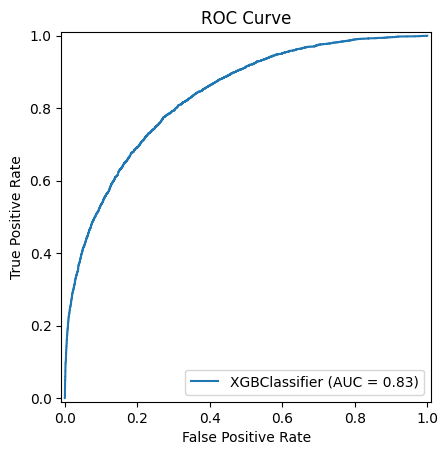



Running model with top 20 features:
Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)
Score: 0.9166171828608932
Predictions: [0 0 0 ... 0 0 0]
Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
            

/Users/rosssponholtz/code/cs598dlh-project/.venv/lib/python3.11/site-packages/sklearn/utils/_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


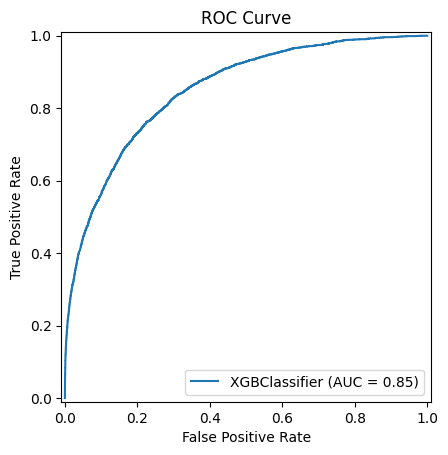

In [9]:
for feature_count in [10, 15, 20]:
    print(f"\n\nRunning model with top {feature_count} features:")
    new_dfX = dfX[selected_columns[0:feature_count]].copy()
    model = run_model(new_dfX, dfy)